# JEL_thermo-el-ROM: Machine Learned Model

## Hierarchical Sampling, MSE loss function (WIP)

### Imports:

In [1]:
# imports
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from statsmodels.distributions.empirical_distribution import ECDF
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import data, models, utils
# reproducability
torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

### Load DNS data from HDF5 file:

3 datasets are available, but for now only `dset_0` is used.
The sample at 293K is omitted since the thermal strain is zero there.

In [2]:
data_dir = utils.get_file_dir() / 'data'
ms_file = data_dir / 'generated_rve10_vol40.h5'
ann_file = data_dir / 'generated_rve10_vol40_ann.h5'
file = data.File(ms_file)
print('available groups:', file.group_names())
group = file.group('image_data')
print('available datasets:', group.dataset_names())
dset0 = group.dataset('dset_0')
dset1 = group.dataset('dset_1')

dset = TensorDataset(*dset0[1:]) # omit the sample at 293K
x, y = dset[:]

available groups: ['image_data']
available datasets: ['dset_0', 'dset_1', 'dset_2']


### Data scaling:
As sole input feature the temperature $\theta$ is used.

The output features $y = [\mathrm{vec}(L), E] \in \mathbb{R}^{27}$ are given by the Cholesky decomposition $L$ of the Mandel notation $C = L L^\intercal$ of the fourth-order effective stiffness tensor $\mathbb{C}$ and the Mandel notation $E \in \mathbb{R}^6$ of the thermal strain tensor $\varepsilon_\theta$ that are obtained by the DNS.

Since the different components of $y$ differ greatly in magnitude, each output feature is normalized with its absolute maximum value.

In [3]:
# Scaling
y_ref = torch.max(torch.abs(dset[:][1]), axis=0)[0]

dset = TensorDataset(dset[:][0], dset[:][1] / y_ref)
x, y = dset[:]

The scaled data is plotted in the figure below.

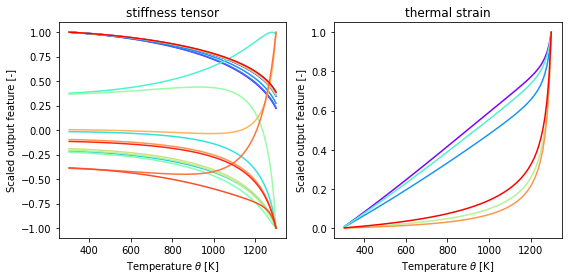

In [4]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
colors = cm.rainbow(np.linspace(0, 1, 21))
for i in range(21):
    ax[0].plot(x, y[:,i], '-', color=colors[i])
    ax[0].set_title('stiffness tensor')
    ax[0].set_xlabel(r'Temperature $\theta$ [K]')
    ax[0].set_ylabel(r'Scaled output feature [-]')
colors = cm.rainbow(np.linspace(0, 1, 6))
for i in range(21, 27):
    ax[1].plot(x, y[:,i], '-', color=colors[i-21])
    ax[1].set_title('thermal strain')
    ax[1].set_xlabel(r'Temperature $\theta$ [K]')
    ax[1].set_ylabel(r'Scaled output feature [-]')
plt.tight_layout()
plt.show()

### Reconstruct the effective material parameters:

In [5]:
# Look at the first sample:
x0, y0 = x[0], y[0]
np.set_printoptions(precision=3)
print('input feature: temperature', x0[0].numpy())
print('output features:')
print(y0.numpy())
C, thermal_strain = data.Dataset.parse_eff_parameters(y0 * y_ref)
print('reconstructed stiffness tensor in Mandel notation C:')
print(C)
print('reconstructed thermal strain in Mandel notation eps_theta:')
print(thermal_strain.numpy())

input feature: temperature 303.17
output features:
[ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
 -2.136e-01 -1.563e-02  3.767e-01  1.000e+00 -2.249e-01  3.667e-01
 -2.054e-01 -1.896e-01  1.000e+00  4.411e-03 -9.634e-02 -3.906e-01
 -3.853e-01 -1.157e-01  1.000e+00  7.755e-03  6.105e-03  7.209e-03
  5.732e-04  3.250e-04  9.189e-04]
reconstructed stiffness tensor in Mandel notation C:
[[ 2.891e+08  1.305e+08  1.310e+08 -1.221e+06 -2.252e+05  3.634e+03]
 [ 1.305e+08  2.861e+08  1.304e+08 -6.350e+05  2.419e+05 -3.044e+05]
 [ 1.310e+08  1.304e+08  2.883e+08  2.629e+04 -5.409e+05 -3.693e+05]
 [-1.221e+06 -6.350e+05  2.629e+04  1.552e+08 -5.243e+05 -2.967e+05]
 [-2.252e+05  2.419e+05 -5.409e+05 -5.243e+05  1.548e+08 -2.669e+05]
 [ 3.634e+03 -3.044e+05 -3.693e+05 -2.967e+05 -2.669e+05  1.572e+08]]
reconstructed thermal strain in Mandel notation eps_theta:
[1.063e-04 1.093e-04 1.070e-04 1.547e-06 4.283e-07 5.553e-07]


### Data sampling:

In [6]:
def hierarchical_sampling(dset, temperatures):
    """Select the data points that are closest to a given list of `temperatures`
    TODO: sample extra validation data

    :param dset: _description_
    :type dset: _type_
    :param temperatures: _description_
    :type temperatures: _type_
    :return: _description_
    :rtype: _type_
    """
    train_idx = [int(torch.argmin(torch.abs(x - t))) for t in temperatures]
    train_data = TensorDataset(*dset[train_idx])
    return train_data, train_data

Temperatures lists for the hierarchical data sampling that are based on "octahedron_combo_32x32x32.h5":

In [7]:
temperatures_0 = [293., 1300.]
temperatures_1 = [293., 1127.08080808, 1300.]
temperatures_2 = [293., 1127.08080808, 1238.96969697, 1300.]
temperatures_3 = [293., 903.3030303, 1127.08080808, 1238.96969697, 1300.]
temperatures_4 = [293., 903.3030303, 1127.08080808, 1238.96969697, 1279.65656566, 1300.]

#### Hierarchical sampling: level 0 (2 training samples), no extra validation data

In [8]:
# Split in test and validation data
train_data0a, val_data0a = hierarchical_sampling(dset, temperatures_0)

# Create dataloaders
batch_size = len(train_data0a)
train_loader0a = DataLoader(train_data0a, batch_size=batch_size, shuffle=True)
val_loader0a = DataLoader(val_data0a, batch_size=len(val_data0a))

# Plot datasets
train_x0a, train_y0a = utils.get_data(train_loader0a)
val_x0a, val_y0a = utils.get_data(val_loader0a)

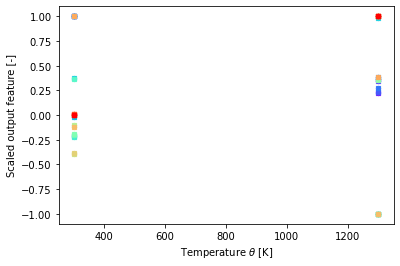

In [9]:
def plot_train_val_data(ax, train_x, train_y, val_x, val_y):
    colors = cm.rainbow(np.linspace(0, 1, train_y.size(1)))
    for i in range(train_y.size(1)):
        ax.scatter(train_x, train_y[:,i], marker='o', s=20, color=colors[i])
        ax.scatter(val_x, val_y[:,i], marker='x', s=20, color=colors[i])
        ax.set_xlabel(r'Temperature $\theta$ [K]')
        ax.set_ylabel(r'Scaled output feature [-]')
    plt.show()

fig, ax = plt.subplots()
plot_train_val_data(ax, train_x0a, train_y0a, val_x0a, val_y0a)

Create a PyTorch model for a Feedforward Artificial Neural Network (FFANN) with 2 hidden layers and 64 neurons per layer. `Tanh` is used as activation function in the hidden layers and the identity as activation function in the output layer.

In [10]:
model0a = models.RectFFModule(x.size(1), 64, 2, nn.Tanh(), nn.Identity(), y.size(1))
print(model0a)

RectFFModule(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=27, bias=True)
    (1): Identity()
  )
)


The MSE loss function is used for training. Using the "mechanical loss function", which is defined as $$\frac{||L_{pred} - L||_F}{||L||_F} + \frac{||\varepsilon_{\theta,pred} - \varepsilon_{\theta}||_F}{||\varepsilon_\theta||_F}$$ causes difficulties since $||\varepsilon_\theta||_F$ is close to zero for $\theta$ near 293K.

Here, using the Adam as optimizer leads to faster convergence than using Stochastic Gradient Descent (SGD).

In [11]:
loss_fn = nn.MSELoss(reduction='mean')
#loss_fn = models.MS1Model.mech_loss
optimizer0a = torch.optim.Adam(model0a.parameters(), lr=2e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

The model is trained using the sampled training data for a given number of epochs. Note that in this case the validation data is the same as the training data and hence the validation and training loss coincicde.

In [12]:
epochs = 5000
train_losses0a, val_losses0a, best_epoch0a = utils.model_training(model0a, loss_fn, optimizer0a, train_loader0a, val_loader0a, epochs, verbose=True)

Epoch 1000: training loss 0.001941, validation loss 0.001941
Epoch 2000: training loss 0.000000, validation loss 0.000000
Epoch 3000: training loss 0.000000, validation loss 0.000000
Epoch 4000: training loss 0.000000, validation loss 0.000000
Epoch 5000: training loss 0.000000, validation loss 0.000000


The training history of the ANN is plotted in the figure below.

Best epoch (4990): training loss 2.643057e-15, validation loss 2.643057e-15


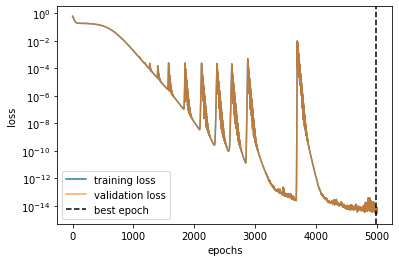

In [13]:
fig, ax = plt.subplots()
utils.plot_training_history(ax, train_losses0a, val_losses0a, best_epoch0a)

The predictions of the ANN are compared to the ground truth in the figure below.

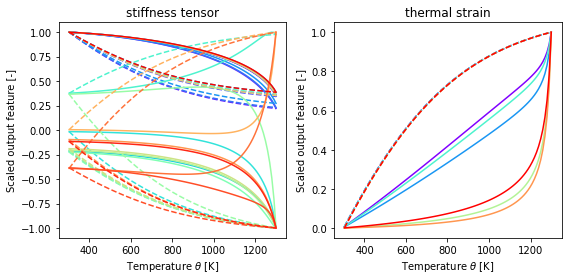

In [14]:
def plot_predictions(ax, x, y, y_pred):
    colors = cm.rainbow(np.linspace(0, 1, 21))
    for i in range(21):
        ax[0].plot(x, y[:,i], '-', color=colors[i])
        ax[0].plot(x, y_pred[:,i].detach().numpy(), '--', color=colors[i])
        ax[0].set_title('stiffness tensor')
        ax[0].set_xlabel(r'Temperature $\theta$ [K]')
        ax[0].set_ylabel(r'Scaled output feature [-]')
    colors = cm.rainbow(np.linspace(0, 1, 6))
    for i in range(21, 27):
        ax[1].plot(x, y[:,i], '-', color=colors[i-21])
        ax[1].plot(x, y_pred[:,i].detach().numpy(), '--', color=colors[i-21])
        ax[1].set_title('thermal strain')
        ax[1].set_xlabel(r'Temperature $\theta$ [K]')
        ax[1].set_ylabel(r'Scaled output feature [-]')

y_pred0a = model0a(x)
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_predictions(ax, x, y, y_pred0a)
plt.tight_layout()
plt.show()

Plot of the absolute error of the predictions component-wise and the maximum error in comparison to the other samplings:

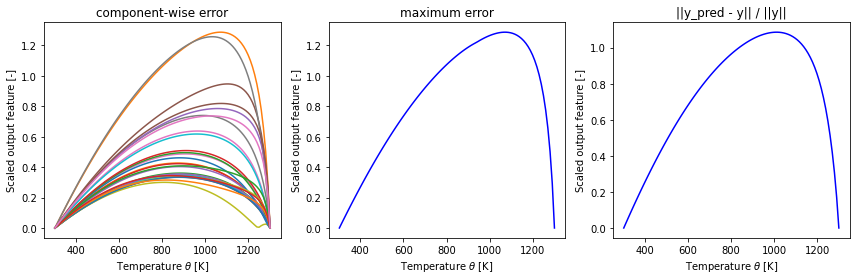

In [15]:
def plot_errors(ax, x, y, y_pred):
    ax.plot(x, np.abs(y.numpy() - y_pred.detach().numpy()), '-')
    ax.set_title('component-wise error')
    ax.set_xlabel(r'Temperature $\theta$ [K]')
    ax.set_ylabel(r'Scaled output feature [-]')

def plot_max_error(ax, x, y, y_pred, label='', style='-'):
    ax.plot(x, np.max(np.abs(y.numpy() - y_pred.detach().numpy()), axis=1), style, label=label)
    ax.set_title('maximum error')
    ax.set_xlabel(r'Temperature $\theta$ [K]')
    ax.set_ylabel(r'Scaled output feature [-]')

def plot_norm_error(ax, x, y, y_pred, label='', style='-'):
    norm_error = np.linalg.norm(y.numpy() - y_pred.detach().numpy(), axis=1) / np.linalg.norm(y.numpy(), axis=1)
    ax.plot(x, norm_error, style, label=label)
    ax.set_title('||y_pred - y|| / ||y||')
    ax.set_xlabel(r'Temperature $\theta$ [K]')
    ax.set_ylabel(r'Scaled output feature [-]')

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
plot_errors(ax[0], x, y, y_pred0a)
plot_max_error(ax[1], x, y, y_pred0a, label='0 levels', style='b-')
plot_norm_error(ax[2], x, y, y_pred0a, label='0 levels', style='b-')
plt.tight_layout()
plt.show()

ECDF plots for different error measures.

"stiffness error": $$\frac{||L_{pred} - L||_F}{||L||_F}$$

"thermal stain error": $$\frac{||\varepsilon_{\theta,pred} - \varepsilon_{\theta}||_F}{||\varepsilon_\theta||_F}$$

"mechanical error": $$\frac{||L_{pred} - L||_F}{||L||_F} + \frac{||\varepsilon_{\theta,pred} - \varepsilon_{\theta}||_F}{||\varepsilon_\theta||_F}$$

Besides, the mean absolute error, mean relative error and mean root-mean-square (RMS) are investigated for all samples from the dataset.

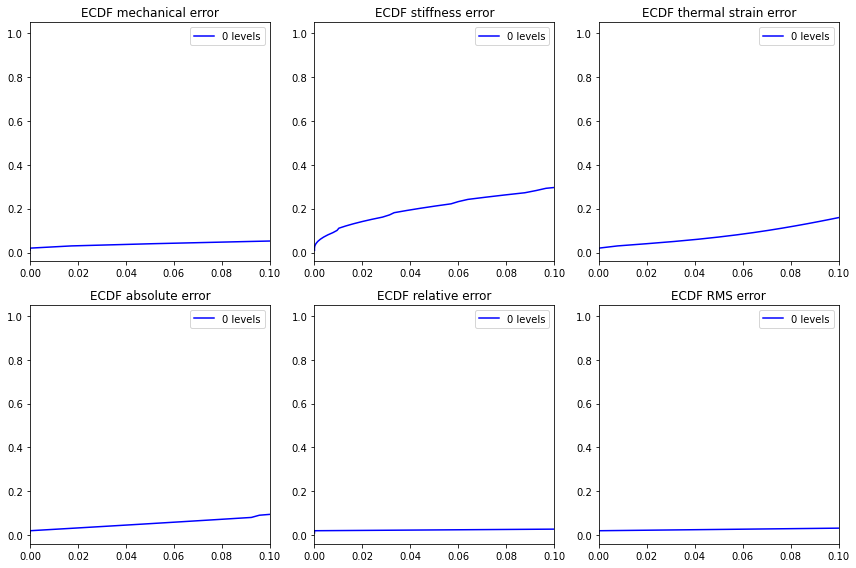

In [16]:
def plot_ecdf(ax, y, y_pred, y_ref, label='ECDF', style='-'):
    mech_error = models.MS1Model.mech_loss(y * y_ref, y_pred * y_ref, reduction='none').detach()
    stiffness_error = models.MS1Model.stiffness_loss(y * y_ref, y_pred * y_ref, reduction='none').detach()
    thermal_exp_error = models.MS1Model.thermal_exp_loss(y * y_ref, y_pred * y_ref, reduction='none').detach()
    absolute_error = torch.mean(torch.abs(y - y_pred), axis=1).detach()
    relative_error = torch.mean(torch.abs((y - y_pred) / y), axis=1).detach()
    rms_error = torch.sqrt(torch.sum(torch.square(y - y_pred), axis=1).detach())
    ecdf_mech = ECDF(mech_error)
    ecdf_stiffness = ECDF(stiffness_error)
    ecdf_thermal_exp = ECDF(thermal_exp_error)
    ecdf_absolute = ECDF(absolute_error)
    ecdf_relative = ECDF(relative_error)
    ecdf_rms = ECDF(rms_error)
    ax[0,0].plot(ecdf_mech.x, ecdf_mech.y, style, label=label)
    ax[0,0].set_title('ECDF mechanical error')
    ax[0,0].set_xlim([0, 0.1])
    ax[0,1].plot(ecdf_stiffness.x, ecdf_stiffness.y, style, label=label)
    ax[0,1].set_title('ECDF stiffness error')
    ax[0,1].set_xlim([0, 0.1])
    ax[0,2].plot(ecdf_thermal_exp.x, ecdf_thermal_exp.y, style, label=label)
    ax[0,2].set_title('ECDF thermal strain error')
    ax[0,2].set_xlim([0, 0.1])
    ax[1,0].plot(ecdf_absolute.x, ecdf_absolute.y, style, label=label)
    ax[1,0].set_title('ECDF absolute error')
    ax[1,0].set_xlim([0, 0.1])
    ax[1,1].plot(ecdf_relative.x, ecdf_relative.y, style, label=label)
    ax[1,1].set_title('ECDF relative error')
    ax[1,1].set_xlim([0, 0.1])
    ax[1,2].plot(ecdf_rms.x, ecdf_rms.y, style, label=label)
    ax[1,2].set_title('ECDF RMS error')
    ax[1,2].set_xlim([0, 0.1])
    for iy, ix in np.ndindex(ax.shape):
        ax[iy, ix].legend()

fig, ax = plt.subplots(2, 3, figsize=[12, 8])
plot_ecdf(ax, y, y_pred0a, y_ref, label='0 levels', style='b-')
plt.tight_layout()
plt.show()

Reconstruct the effective material parameters based on the predictions:

In [17]:
# Look at the first sample:
x0, y0 = x[0], y_pred0a[0].detach()
np.set_printoptions(precision=3)
print('input feature: temperature', x0[0].numpy())
print('output features:')
print(y0.numpy())
C, thermal_strain = data.Dataset.parse_eff_parameters(y0 * y_ref)
print('reconstructed stiffness tensor in Mandel notation C:')
print(C)
print('reconstructed thermal strain in Mandel notation eps_theta:')
print(thermal_strain.numpy())

input feature: temperature 303.17
output features:
[ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
 -2.136e-01 -1.563e-02  3.767e-01  1.000e+00 -2.249e-01  3.667e-01
 -2.054e-01 -1.896e-01  1.000e+00  4.411e-03 -9.634e-02 -3.906e-01
 -3.853e-01 -1.157e-01  1.000e+00  7.755e-03  6.105e-03  7.209e-03
  5.732e-04  3.249e-04  9.189e-04]
reconstructed stiffness tensor in Mandel notation C:
[[ 2.891e+08  1.305e+08  1.310e+08 -1.221e+06 -2.252e+05  3.634e+03]
 [ 1.305e+08  2.861e+08  1.304e+08 -6.350e+05  2.419e+05 -3.044e+05]
 [ 1.310e+08  1.304e+08  2.883e+08  2.629e+04 -5.409e+05 -3.693e+05]
 [-1.221e+06 -6.350e+05  2.629e+04  1.552e+08 -5.243e+05 -2.967e+05]
 [-2.252e+05  2.419e+05 -5.409e+05 -5.243e+05  1.548e+08 -2.669e+05]
 [ 3.634e+03 -3.044e+05 -3.693e+05 -2.967e+05 -2.669e+05  1.572e+08]]
reconstructed thermal strain in Mandel notation eps_theta:
[1.063e-04 1.093e-04 1.070e-04 1.547e-06 4.282e-07 5.553e-07]


Save the model predictions to a HDF5 file:

In [18]:
def save_predictions(x, y_pred, y_ref, file_name, group_name, sampling_strategy=''):
    with data.File(file_name, 'a') as file:
        group = file.require_group(group_name)
        group.attrs['sampling_strategy'] = sampling_strategy
        for i in range(x.size(0)):
            temperature = x[i,0].numpy()
            C, thermal_strain = data.Dataset.parse_eff_parameters(y[i,:] * y_ref)
            dset_temperature = group.require_dataset(f'temperature_{temperature:07.2f}', (1,), dtype='f')
            dset_stiffness = group.require_dataset(f'eff_stiffness_{temperature:07.2f}', (6,6), dtype='f')
            dset_thermal_strain = group.require_dataset(f'eff_thermal_strain_{temperature:07.2f}', (6,), dtype='f')
            dset_temperature[:] = temperature
            dset_stiffness[:] = C
            dset_thermal_strain[:] = thermal_strain

save_predictions(x, y_pred0a, y_ref, ann_file, 'hierarchical_0', 'Hierarchical sampling: 0 levels (2 training samples), no extra validation data')

#### Hierarchical sampling: 1 level (3 training samples), no extra validation data

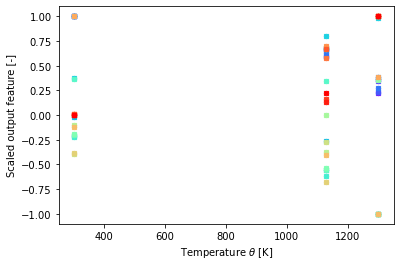

In [19]:
# Reproducability:
torch.manual_seed(1)

# Split in test and validation data
train_data1a, val_data1a = hierarchical_sampling(dset, temperatures_1)

# Create dataloaders
batch_size = len(train_data1a)
train_loader1a = DataLoader(train_data1a, batch_size=batch_size, shuffle=True)
val_loader1a = DataLoader(val_data1a, batch_size=len(val_data1a))

# Plot datasets
train_x1a, train_y1a = utils.get_data(train_loader1a)
val_x1a, val_y1a = utils.get_data(val_loader1a)

fig, ax = plt.subplots()
plot_train_val_data(ax, train_x1a, train_y1a, val_x1a, val_y1a)

Best epoch (9857): training loss 2.651402e-05, validation loss 2.651402e-05


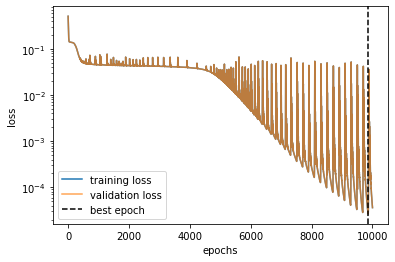

In [20]:
model1a = models.RectFFModule(x.size(1), 64, 2, nn.Tanh(), nn.Identity(), y.size(1))
loss_fn = nn.MSELoss(reduction='mean')
optimizer1a = torch.optim.Adam(model1a.parameters(), lr=5e-4)
epochs = 10000
train_losses1a, val_losses1a, best_epoch = utils.model_training(model1a, loss_fn, optimizer1a, train_loader1a, val_loader1a, epochs, verbose=False)
fig, ax = plt.subplots()
utils.plot_training_history(ax, train_losses1a, val_losses1a, best_epoch)

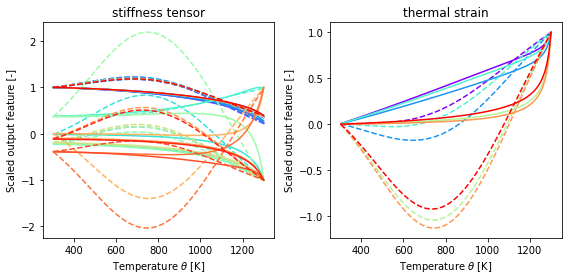

In [21]:
y_pred1a = model1a(x)
save_predictions(x, y_pred1a, y_ref, ann_file, 'hierarchical_1', 'Hierarchical sampling: 1 level (3 training samples), no extra validation data')

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_predictions(ax, x, y, y_pred1a)
plt.tight_layout()
plt.show()

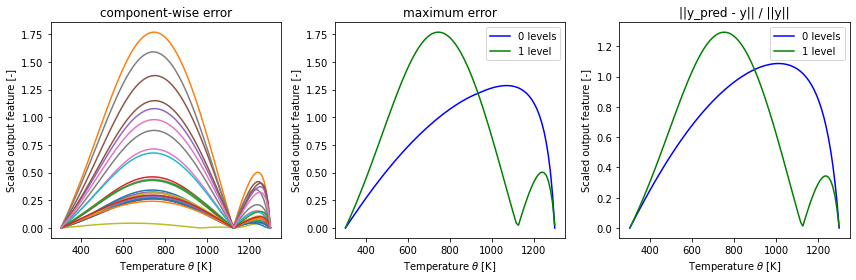

In [22]:
fig, ax = plt.subplots(1, 3, figsize=[12, 4])
plot_errors(ax[0], x, y, y_pred1a)
plot_max_error(ax[1], x, y, y_pred0a, label='0 levels', style='b-')
plot_max_error(ax[1], x, y, y_pred1a, label='1 level', style='g-')
plot_norm_error(ax[2], x, y, y_pred0a, label='0 levels', style='b-')
plot_norm_error(ax[2], x, y, y_pred1a, label='1 level', style='g-')
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

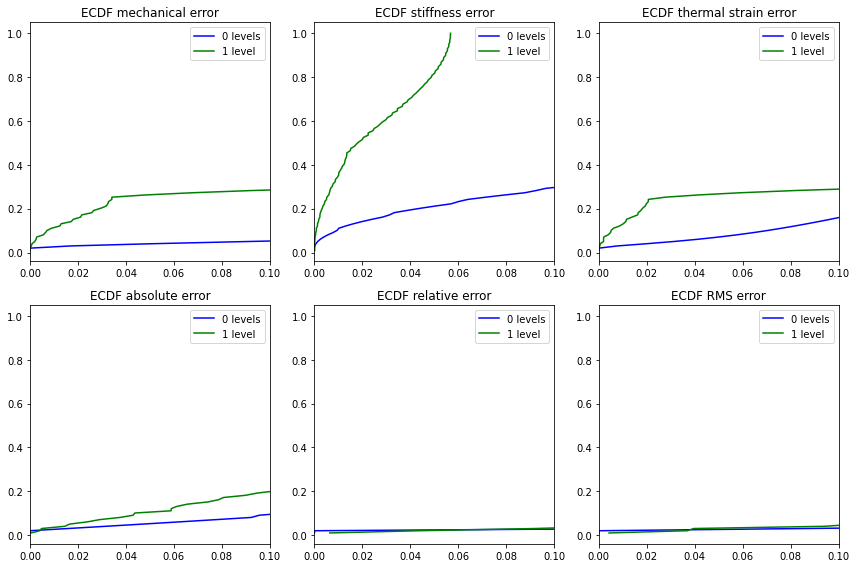

In [23]:
fig, ax = plt.subplots(2, 3, figsize=[12, 8])
plot_ecdf(ax, y, y_pred0a, y_ref, label='0 levels', style='b-')
plot_ecdf(ax, y, y_pred1a, y_ref, label='1 level', style='g-')
plt.tight_layout()
plt.show()

#### Hierarchical sampling: 2 levels (4 training samples), no extra validation data

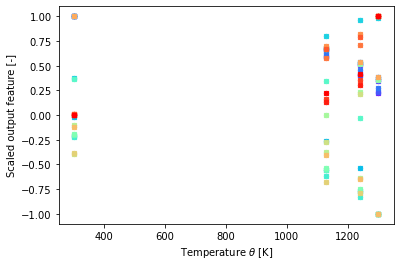

In [24]:
# Reproducability:
torch.manual_seed(1)

# Split in test and validation data
train_data2a, val_data2a = hierarchical_sampling(dset, temperatures_2)

# Create dataloaders
batch_size = len(train_data2a)
train_loader2a = DataLoader(train_data2a, batch_size=batch_size, shuffle=True)
val_loader2a = DataLoader(val_data2a, batch_size=len(val_data2a))

# Plot datasets
train_x2a, train_y2a = utils.get_data(train_loader2a)
val_x2a, val_y2a = utils.get_data(val_loader2a)

fig, ax = plt.subplots()
plot_train_val_data(ax, train_x2a, train_y2a, val_x2a, val_y2a)

Best epoch (19960): training loss 5.548663e-03, validation loss 5.548663e-03


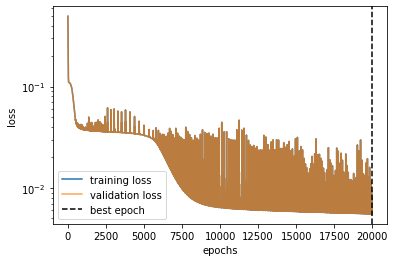

In [25]:
model2a = models.RectFFModule(x.size(1), 64, 2, nn.Tanh(), nn.Identity(), y.size(1))
loss_fn = nn.MSELoss(reduction='mean')
optimizer2a = torch.optim.Adam(model2a.parameters(), lr=4e-4)
epochs = 20000
train_losses2a, val_losses2a, best_epoch = utils.model_training(model2a, loss_fn, optimizer2a, train_loader2a, val_loader2a, epochs, verbose=False)
fig, ax = plt.subplots()
utils.plot_training_history(ax, train_losses2a, val_losses2a, best_epoch)

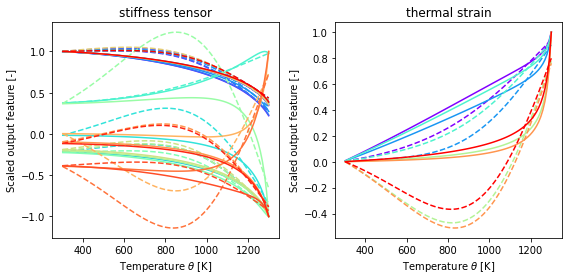

In [26]:
y_pred2a = model2a(x)
save_predictions(x, y_pred2a, y_ref, ann_file, 'hierarchical_2', 'Hierarchical sampling: 2 levels (4 training samples), no extra validation data')

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_predictions(ax, x, y, y_pred2a)
plt.tight_layout()
plt.show()

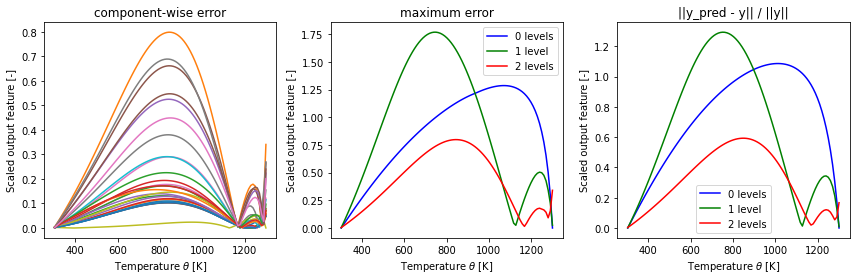

In [27]:
fig, ax = plt.subplots(1, 3, figsize=[12,4])
plot_errors(ax[0], x, y, y_pred2a)
plot_max_error(ax[1], x, y, y_pred0a, label='0 levels', style='b-')
plot_max_error(ax[1], x, y, y_pred1a, label='1 level', style='g-')
plot_max_error(ax[1], x, y, y_pred2a, label='2 levels', style='r-')
plot_norm_error(ax[2], x, y, y_pred0a, label='0 levels', style='b-')
plot_norm_error(ax[2], x, y, y_pred1a, label='1 level', style='g-')
plot_norm_error(ax[2], x, y, y_pred2a, label='2 levels', style='r-')
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

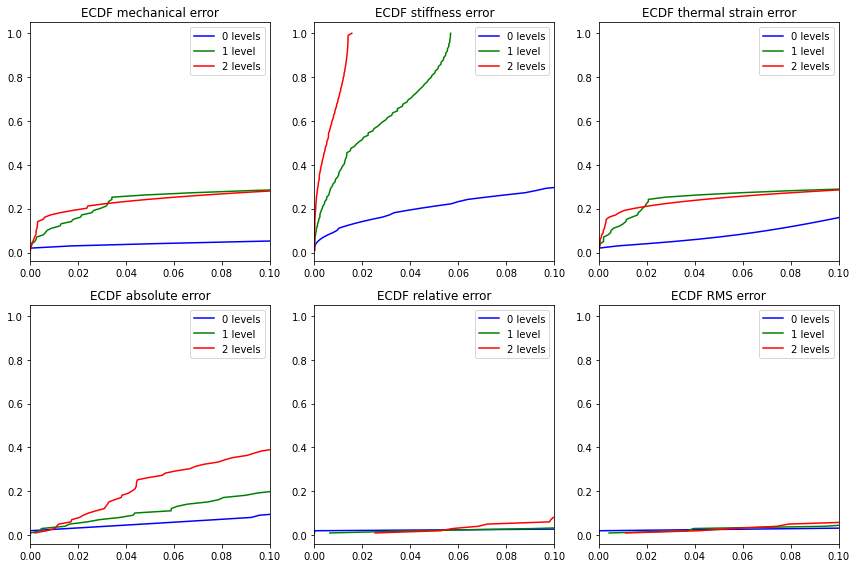

In [28]:
fig, ax = plt.subplots(2, 3, figsize=[12, 8])
plot_ecdf(ax, y, y_pred0a, y_ref, label='0 levels', style='b-')
plot_ecdf(ax, y, y_pred1a, y_ref, label='1 level', style='g-')
plot_ecdf(ax, y, y_pred2a, y_ref, label='2 levels', style='r-')
plt.tight_layout()
plt.show()

#### Hierarchical sampling: 3 levels (5 training samples), no extra validation data

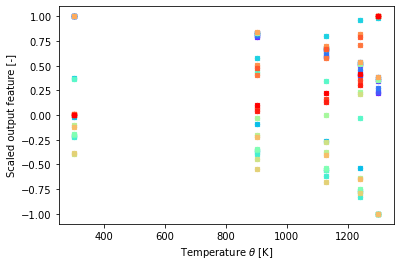

In [29]:
# Reproducability:
torch.manual_seed(1)

# Split in test and validation data
train_data3a, val_data3a = hierarchical_sampling(dset, temperatures_3)

# Create dataloaders
batch_size = len(train_data3a)
train_loader3a = DataLoader(train_data3a, batch_size=batch_size, shuffle=True)
val_loader3a = DataLoader(val_data3a, batch_size=len(val_data3a))

# Plot datasets
train_x3a, train_y3a = utils.get_data(train_loader3a)
val_x3a, val_y3a = utils.get_data(val_loader3a)

fig, ax = plt.subplots()
plot_train_val_data(ax, train_x3a, train_y3a, val_x3a, val_y3a)

Best epoch (24964): training loss 2.718580e-03, validation loss 2.718580e-03


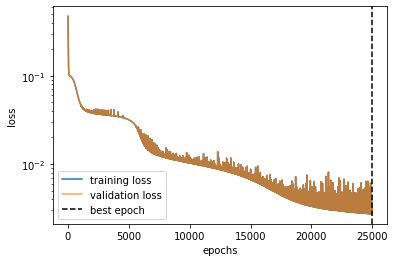

In [30]:
model3a = models.RectFFModule(x.size(1), 64, 2, nn.Tanh(), nn.Identity(), y.size(1))
loss_fn = nn.MSELoss(reduction='mean')
optimizer3a = torch.optim.Adam(model3a.parameters(), lr=2e-4)
epochs = 25000
train_losses3a, val_losses3a, best_epoch = utils.model_training(model3a, loss_fn, optimizer3a, train_loader3a, val_loader3a, epochs, verbose=False)
fig, ax = plt.subplots()
utils.plot_training_history(ax, train_losses3a, val_losses3a, best_epoch)

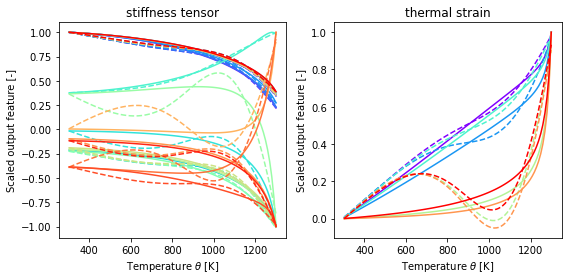

In [31]:
y_pred3a = model3a(x)
save_predictions(x, y_pred3a, y_ref, ann_file, 'hierarchical_3', 'Hierarchical sampling: 3 levels (5 training samples), no extra validation data')

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_predictions(ax, x, y, y_pred3a)
plt.tight_layout()
plt.show()

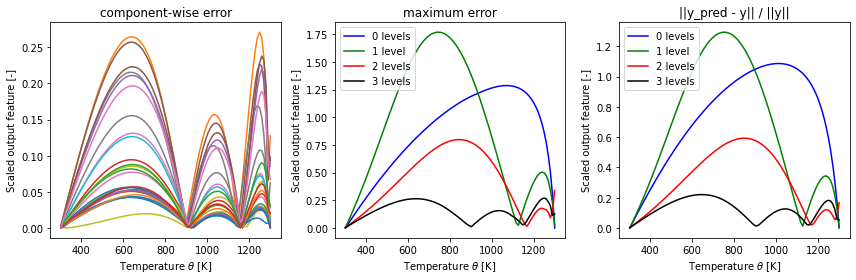

In [32]:
fig, ax = plt.subplots(1, 3, figsize=[12,4])
plot_errors(ax[0], x, y, y_pred3a)
plot_max_error(ax[1], x, y, y_pred0a, label='0 levels', style='b-')
plot_max_error(ax[1], x, y, y_pred1a, label='1 level', style='g-')
plot_max_error(ax[1], x, y, y_pred2a, label='2 levels', style='r-')
plot_max_error(ax[1], x, y, y_pred3a, label='3 levels', style='k-')
plot_norm_error(ax[2], x, y, y_pred0a, label='0 levels', style='b-')
plot_norm_error(ax[2], x, y, y_pred1a, label='1 level', style='g-')
plot_norm_error(ax[2], x, y, y_pred2a, label='2 levels', style='r-')
plot_norm_error(ax[2], x, y, y_pred3a, label='3 levels', style='k-')
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()


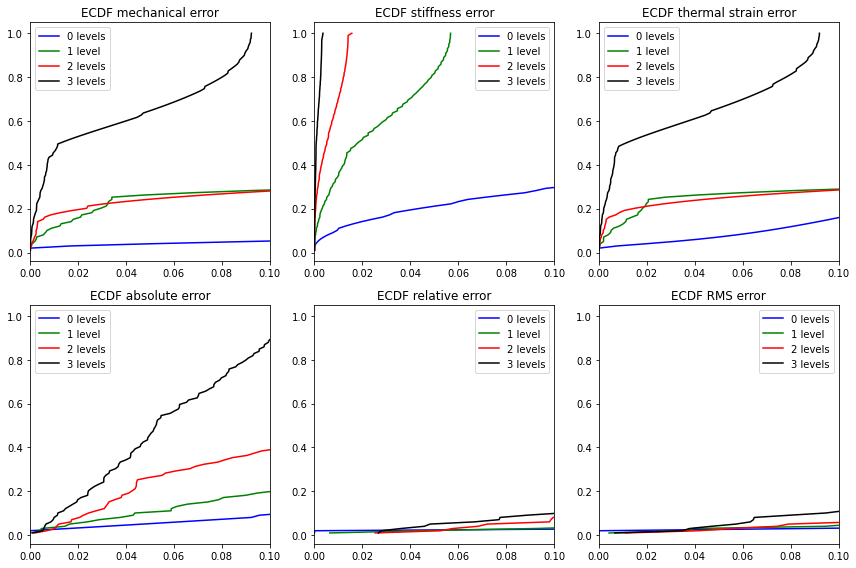

In [33]:
fig, ax = plt.subplots(2, 3, figsize=[12, 8])
plot_ecdf(ax, y, y_pred0a, y_ref, label='0 levels', style='b-')
plot_ecdf(ax, y, y_pred1a, y_ref, label='1 level', style='g-')
plot_ecdf(ax, y, y_pred2a, y_ref, label='2 levels', style='r-')
plot_ecdf(ax, y, y_pred3a, y_ref, label='3 levels', style='k-')
plt.tight_layout()
plt.show()